In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import pickle
from calcwf import *
from interpolating_match import *

Let's first take a look at the (quad) mismatch between harmonics generated at different fiducial eccentricities with the non-eccentric waveform along the degeneracy line for different chirp masses.

In [2]:
# Find mismatches for a range of fid_e values
def find_quad_mismatches(chirp, fid_es, n, q=2, f_low=10, sample_rate=4096, approximant='TEOBResumS'):

    # Generate non-eccentric waveform
    h = gen_wf(f_low, 0, chirp2total(chirp, q), q, sample_rate, approximant)

    # Generate chirp masses along degeneracy line
    fid_chirps = chirp_degeneracy_line(chirp, fid_es, sample_rate, f_low=f_low, q=q)

    # Calculate mismatch for each fid_e
    mismatches = []
    for i, (fid_e, fid_chirp) in enumerate(zip(fid_es, fid_chirps)):
        all_wfs = list(get_h([1]*n, f_low, fid_e, chirp2total(fid_chirp, q), q, sample_rate, approximant=approximant))
        matches = match_hn(all_wfs[1:n+1], h, f_low)
        quad_match = np.sqrt(np.sum(np.abs(matches)**2))
        mismatches.append(1-quad_match)
        print(f'\r{i+1} done out of {len(fid_es)}', end='')
    print('')

    return np.array(mismatches)

In [3]:
# Calculate mismatches for 10, 30, and 70 chirp masses
mismatches_10 = find_quad_mismatches(10, np.linspace(0,0.15,16), 4)
mismatches_30 = find_quad_mismatches(30, np.linspace(0,0.30,31), 4)
mismatches_70 = find_quad_mismatches(70, np.linspace(0,0.50,51), 4)

/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:435: RuntimeWarning: divide by zero encountered in power
  return self._data ** other
/home/ben.patterson/.conda/envs/teobresums_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:348: RuntimeWarning: invalid value encountered in multiply
  return self._data * other


16 done out of 16
31 done out of 31
51 done out of 51


(0.0, 0.007)

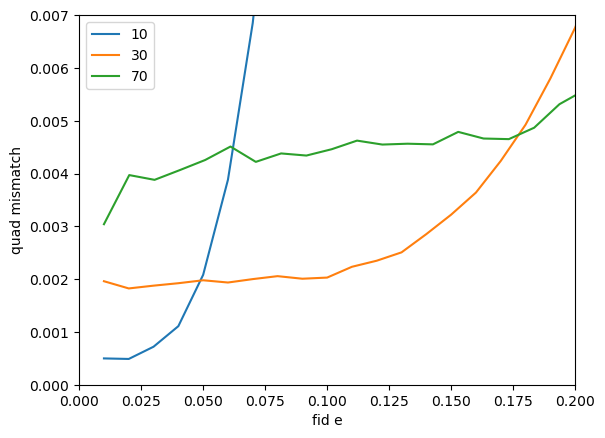

In [4]:
plt.plot(np.linspace(0.01,0.15,15), mismatches_10[1:], label='10')
plt.plot(np.linspace(0.01,0.30,30), mismatches_30[1:], label='30')
plt.plot(np.linspace(0.01,0.51,50), mismatches_70[1:], label='70')
plt.legend()
plt.xlabel('fid e')
plt.ylabel('quad mismatch')
plt.xlim(0,0.2)
plt.ylim(0,0.007)

Seems like this idea of holding the quad mismatch constant is unlikely to work based on this. What if we try mismatch with a teobresums wf instead of our harmonics?

In [5]:
# Find mismatches for a range of fid_e values
def find_mismatches(chirp, fid_es, q=2, f_low=10, sample_rate=4096, approximant='TEOBResumS'):

    # Generate non-eccentric waveform
    h = gen_wf(f_low, 0.001, chirp2total(chirp, q), q, sample_rate, approximant)

    # Generate chirp masses along degeneracy line
    fid_chirps = chirp_degeneracy_line(chirp, fid_es, sample_rate, f_low=f_low, q=q)

    # Calculate mismatch for each fid_e
    mismatches = []
    for i, (fid_e, fid_chirp) in enumerate(zip(fid_es, fid_chirps)):
        s = gen_wf(f_low, fid_e, chirp2total(fid_chirp, q), q, sample_rate, approximant)
        match = match_wfs(s, h, f_low, True)
        mismatches.append(1-match)
        print(f'\r{i+1} done out of {len(fid_es)}', end='')
    print('')

    return np.array(mismatches)

In [6]:
mismatch_10 = find_mismatches(10, np.linspace(0,0.15,16))
mismatch_30 = find_mismatches(30, np.linspace(0,0.30,31))
mismatch_70 = find_mismatches(70, np.linspace(0,0.50,51))

16 done out of 16
31 done out of 31
51 done out of 51


(0.0, 0.22903198817679557)

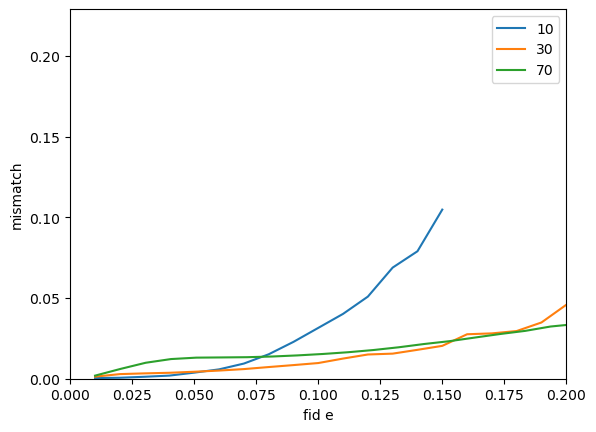

In [7]:
plt.plot(np.linspace(0.01,0.15,15), mismatch_10[1:], label='10')
plt.plot(np.linspace(0.01,0.30,30), mismatch_30[1:], label='30')
plt.plot(np.linspace(0.01,0.51,50), mismatch_70[1:], label='70')
plt.legend()
plt.xlabel('fid e')
plt.ylabel('mismatch')
plt.xlim(0,0.2)
plt.ylim(0)

Also tried giving non-eccentric teobresums wf e=0.001 here, but seems like trying to do this numerically will not work - may instead have to try it analytically by looking at equations similar to those used to derive our line of degeneracy.

First let's look at min/max lines for different fiducial eccentricities at an eccentric chirp mass of 30.

In [2]:
with open(os.path.join('grid_data', 'dataslot_22', 'all_matches'), 'rb') as fp:
        grid_data_0_0p15_16 = pickle.load(fp)
grid_data_0_0p15_16 = find_min_max(grid_data_0_0p15_16)

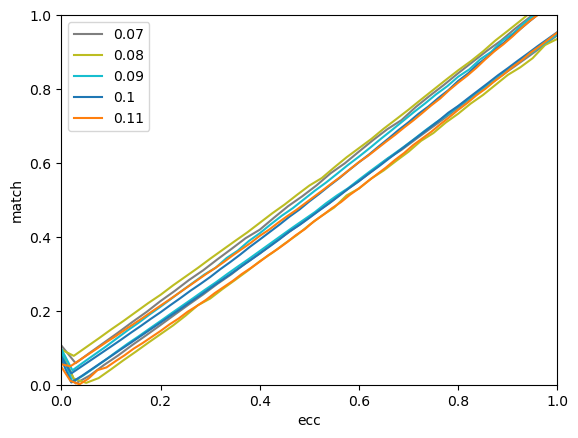

In [36]:
cmap = mpl.colormaps['inferno']
for i, fid_e in enumerate(grid_data_0_0p15_16.keys()):
    if i<7 or i>11:
        continue
    fid_e_arg = int((fid_e-grid_data_0_0p15_16[fid_e]['e_vals'][0])/np.mean(np.diff(grid_data_0_0p15_16[fid_e]['e_vals'])))
    fid_e_match_max = grid_data_0_0p15_16[fid_e]['h1_h0_max'][fid_e_arg]
    fid_e_match_min = grid_data_0_0p15_16[fid_e]['h1_h0_min'][fid_e_arg]
    y_norm = (fid_e_match_max+fid_e_match_min)/2
    plt.plot(grid_data_0_0p15_16[fid_e]['e_vals']/fid_e, grid_data_0_0p15_16[fid_e]['h1_h0_max']/y_norm, c=f'C{i}', label=str(fid_e))
    plt.plot(grid_data_0_0p15_16[fid_e]['e_vals']/fid_e, grid_data_0_0p15_16[fid_e]['h1_h0_min']/y_norm, c=f'C{i}')
    plt.legend()
    plt.ylabel('match')
    plt.xlabel('ecc')
    plt.xlim(0,1)
    plt.ylim(0,1)
    #plt.show()